In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [2]:
sdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_5253_sw_2/'

savedir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_5253_sw_2/Spectra/'

if not os.path.exists(savedir):
    os.makedirs(savedir)

fits_name = 'NGC_5253_sw_2.fits'

In [3]:
hdulist = fits.open(sdir + fits_name)

hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_5253_sw_2/NGC_5253_sw_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     311   ()      
  1  FLUX          1 ImageHDU        28   (33, 35, 47)   float64   
  2  ERROR         1 ImageHDU        28   (33, 35, 47)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (33, 35, 47)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (33, 35, 47)   float64   
  5  WAVELENGTH    1 ImageHDU         7   (47,)   float64   
  6  X             1 ImageHDU         7   (33,)   float64   
  7  Y             1 ImageHDU         7   (35,)   float64   
  8  TRANSMISSION    1 ImageHDU         7   (47,)   float64   
  9  RESPONSE      1 ImageHDU         7   (47,)   float32   
 10  EXPOSURE_MAP    1 ImageHDU        28   (33, 35, 47)   int16   
 11  UNSMOOTHED_TRANSMISSION    1 ImageHDU         8   (1227, 2)   float32   


In [4]:
hdulist[1].header

XTENSION= 'IMAGE   '           /extension type                                  
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                   33 /                                                
NAXIS2  =                   35 /                                                
NAXIS3  =                   47 /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'FLUX    '           /                                                
DATE-OBS= '2019-05-10T06:12:46' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =              2000.00 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'        

In [5]:
wavelengths = hdulist[5].data

x_coords = hdulist[6].data
x_min = x_coords[0]
x_max = x_coords[len(x_coords)-1]

y_coords = hdulist[7].data
y_min = y_coords[0]
y_max = y_coords[len(y_coords)-1]

print(wavelengths)

wav_diff = []

for i in range(0, len(wavelengths)-1):
    wav_diff.append(wavelengths[i+1]-wavelengths[i])
  
wav_diff = np.average(wav_diff)

print(wav_diff)

[57.21331518 57.22128708 57.22925897 57.23723086 57.24520276 57.25317465
 57.26114654 57.26911844 57.27709033 57.28506223 57.29303412 57.30100601
 57.30897791 57.3169498  57.32492169 57.33289359 57.34086548 57.34883738
 57.35680927 57.36478116 57.37275306 57.38072495 57.38869685 57.39666874
 57.40464063 57.41261253 57.42058442 57.42855631 57.43652821 57.4445001
 57.452472   57.46044389 57.46841578 57.47638768 57.48435957 57.49233147
 57.50030336 57.50827525 57.51624715 57.52421904 57.53219093 57.54016283
 57.54813472 57.55610662 57.56407851 57.5720504  57.5800223 ]
0.007971893817146025


In [6]:
# wavelength is the first dimension
# y is the second dimension
# x is the third dimension

fluxmaps = hdulist[1].data

fluxmaps_min = np.nanmin(fluxmaps.flatten())
fluxmaps_max = np.nanmax(fluxmaps.flatten())

print(fluxmaps.shape)

(47, 35, 33)


In [7]:
def sum_spaxel(fluxmap, k_x, k_y):
    
    n_x = len(fluxmap[0])
    n_y = len(fluxmap)
    
    id_x = np.arange(np.floor((n_x-k_x)/2), np.floor((n_x-k_x)/2) + k_x, 1)
    id_x = id_x.astype(int)
    
    id_y = np.arange(np.floor((n_y-k_y)/2), np.floor((n_y-k_y)/2) + k_y, 1)
    id_y = id_y.astype(int)
    
    central_fluxmap = []
    
    for j in id_y:
        
        y_snip = []
        
        for i in id_x:
            
            y_snip.append(fluxmap[j][i])
            
        central_fluxmap.append(y_snip)
            
    central_fluxmap = np.array(central_fluxmap)
    
    central_flux = np.sum(central_fluxmap)
    
    return central_flux

In [8]:
central_fluxes_unfiltered = []

n_x = 5
n_y = 5

for fluxmap in fluxmaps:
    
    central_flux_unfiltered = sum_spaxel(fluxmap, n_x, n_y)
    central_fluxes_unfiltered.append(central_flux_unfiltered)
    
central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

c = 3*10**8

for i in range(0, len(wavelengths)):
    
    wavelength = wavelengths[i]
    
    central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))
    
central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)

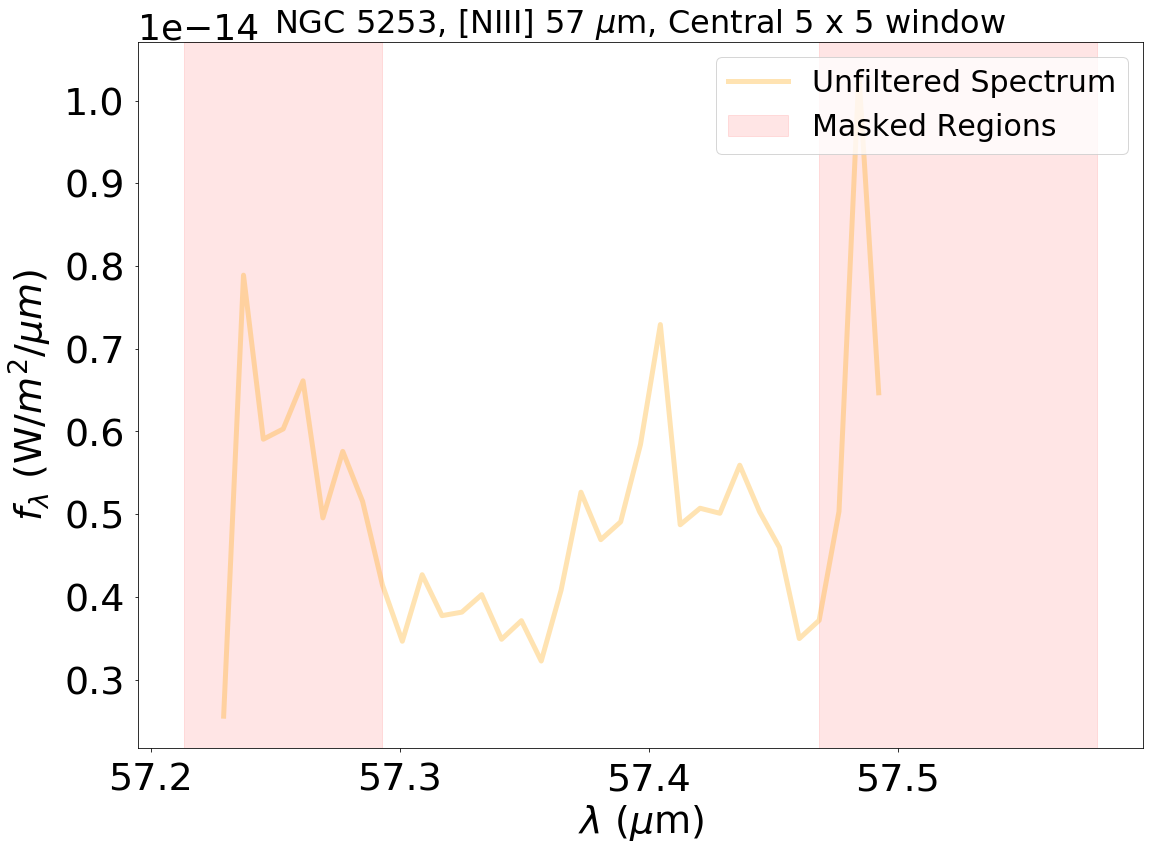

In [9]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.axvspan(wavelengths[0], wavelengths[10], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax.axvspan(wavelengths[-15], wavelengths[-1], color = 'red', alpha = 0.1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 5253, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)
ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_5253_[NIII]-1-unfiltered_spectrum.png'.format(str(n_x), str(n_y)))

In [10]:
print(central_fluxes_unfiltered)

[           nan            nan 2.55773147e-15 7.88891338e-15
 5.90599044e-15 6.02996622e-15 6.61186969e-15 4.95474534e-15
 5.75888637e-15 5.15361048e-15 4.14363792e-15 3.46353266e-15
 4.26808648e-15 3.77301397e-15 3.81535569e-15 4.02653655e-15
 3.48734715e-15 3.71211040e-15 3.22422343e-15 4.08174722e-15
 5.26516234e-15 4.69143902e-15 4.90680535e-15 5.84312924e-15
 7.29199542e-15 4.87167116e-15 5.07132477e-15 5.01055482e-15
 5.59172871e-15 5.02890229e-15 4.59719905e-15 3.49565970e-15
 3.71629189e-15 5.03272672e-15 1.03237639e-14 6.46685795e-15
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan]


In [11]:
central_fluxes_filtered = central_fluxes_unfiltered
central_fluxes_filtered = central_fluxes_filtered[10:-14]

wavelengths_filtered = wavelengths[10:-14]

print(central_fluxes_filtered)

[4.14363792e-15 3.46353266e-15 4.26808648e-15 3.77301397e-15
 3.81535569e-15 4.02653655e-15 3.48734715e-15 3.71211040e-15
 3.22422343e-15 4.08174722e-15 5.26516234e-15 4.69143902e-15
 4.90680535e-15 5.84312924e-15 7.29199542e-15 4.87167116e-15
 5.07132477e-15 5.01055482e-15 5.59172871e-15 5.02890229e-15
 4.59719905e-15 3.49565970e-15 3.71629189e-15]


In [12]:
central_fluxes_filtered_continuum = []

left_cut = 57.36
right_cut = 57.46

for i in range(0, len(wavelengths_filtered)):
    
    wavelength = wavelengths_filtered[i]
    
    if(wavelength < left_cut or wavelength > right_cut):
        central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])
    
    else:
        central_fluxes_filtered_continuum.append(float("Nan"))
        
central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

print(central_fluxes_filtered_continuum)

[4.14363792e-15 3.46353266e-15 4.26808648e-15 3.77301397e-15
 3.81535569e-15 4.02653655e-15 3.48734715e-15 3.71211040e-15
 3.22422343e-15            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 3.49565970e-15 3.71629189e-15]


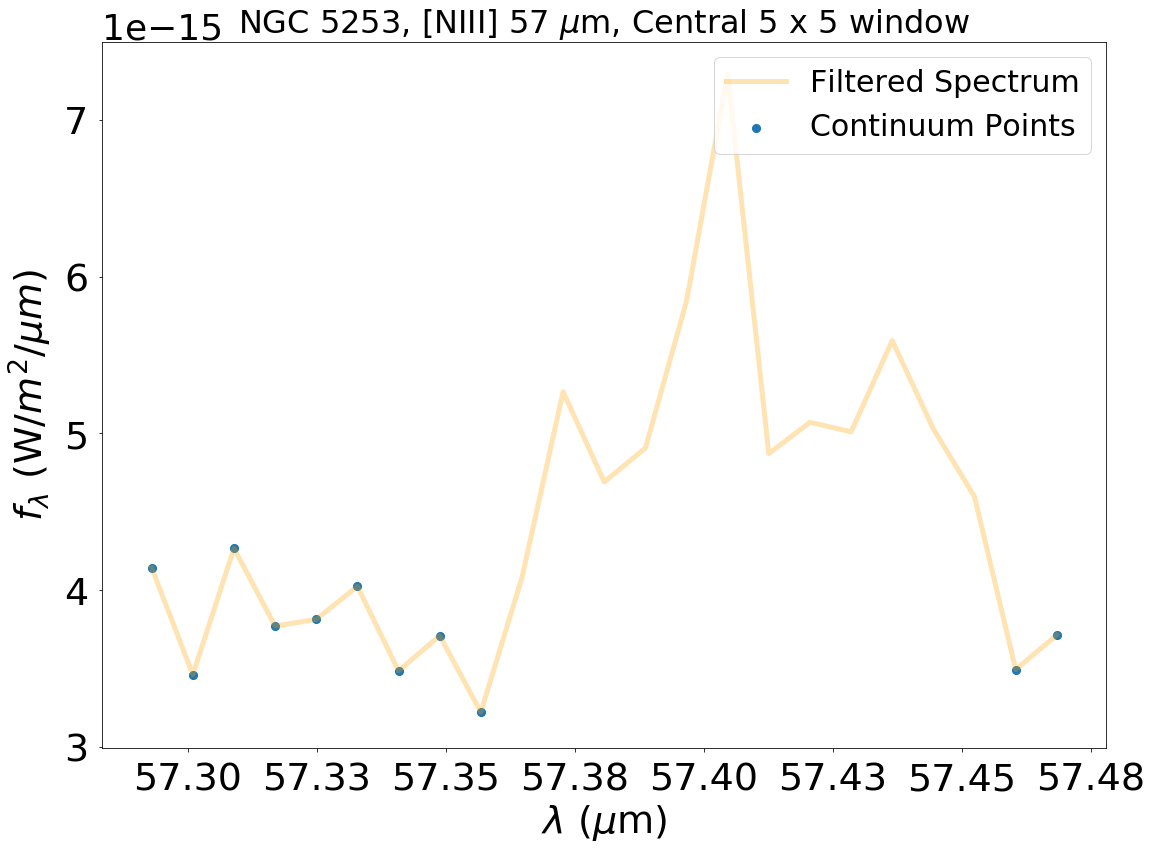

In [13]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 5253, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_5253_[NIII]-2-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [14]:
idcont = np.isfinite(central_fluxes_filtered_continuum)
cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)

print(cont_params)

cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]

[-1.95993257e-15  1.16141404e-13]


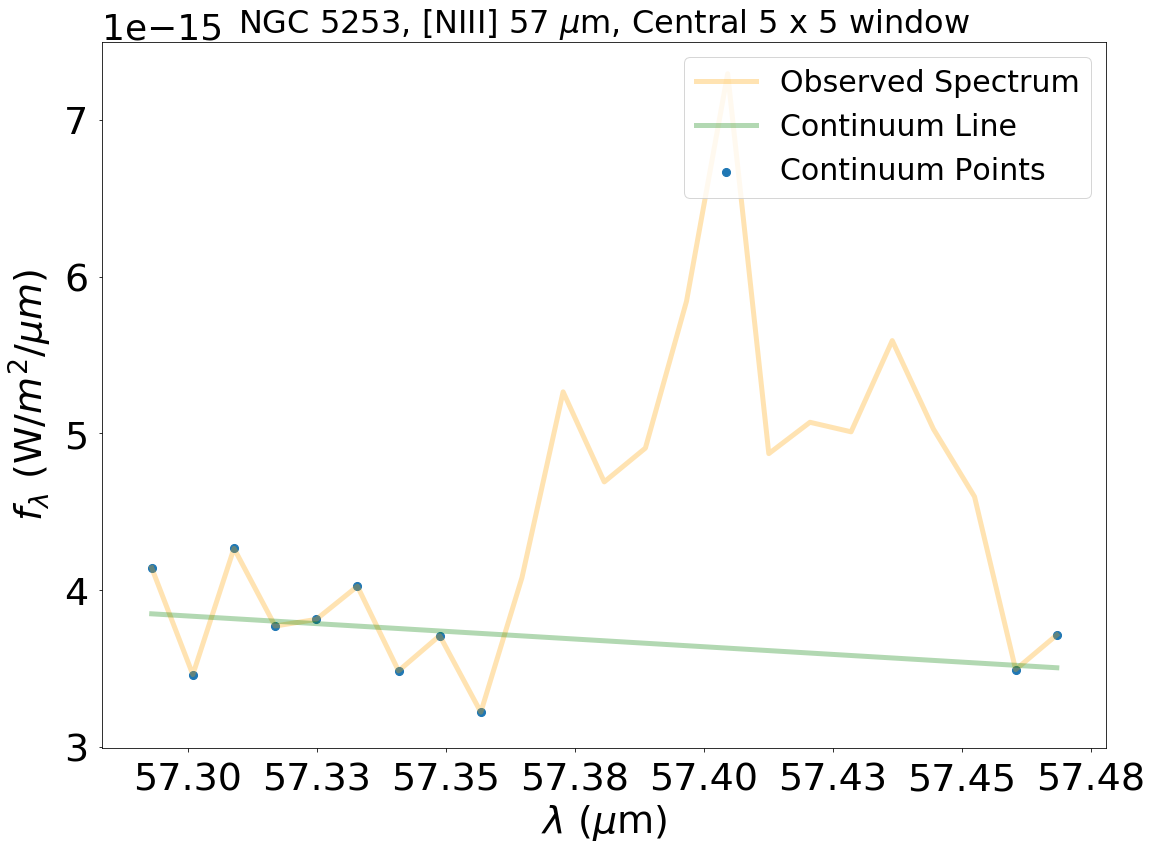

In [15]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 5253, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_5253_[NIII]-3-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [16]:
id_act = np.isnan(central_fluxes_filtered_continuum)

wavelengths_act = wavelengths_filtered[id_act]
central_fluxes_filtered_act = central_fluxes_filtered[id_act]
cont_line_filtered_act = cont_line_filtered[id_act]

central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act

[3.71446457e-16 1.57048595e-15 1.01238701e-15 1.24337772e-15
 2.19532598e-15 3.65981653e-15 1.25511665e-15 1.47039463e-15
 1.42524905e-15 2.02204732e-15 1.47484527e-15 1.05876641e-15]


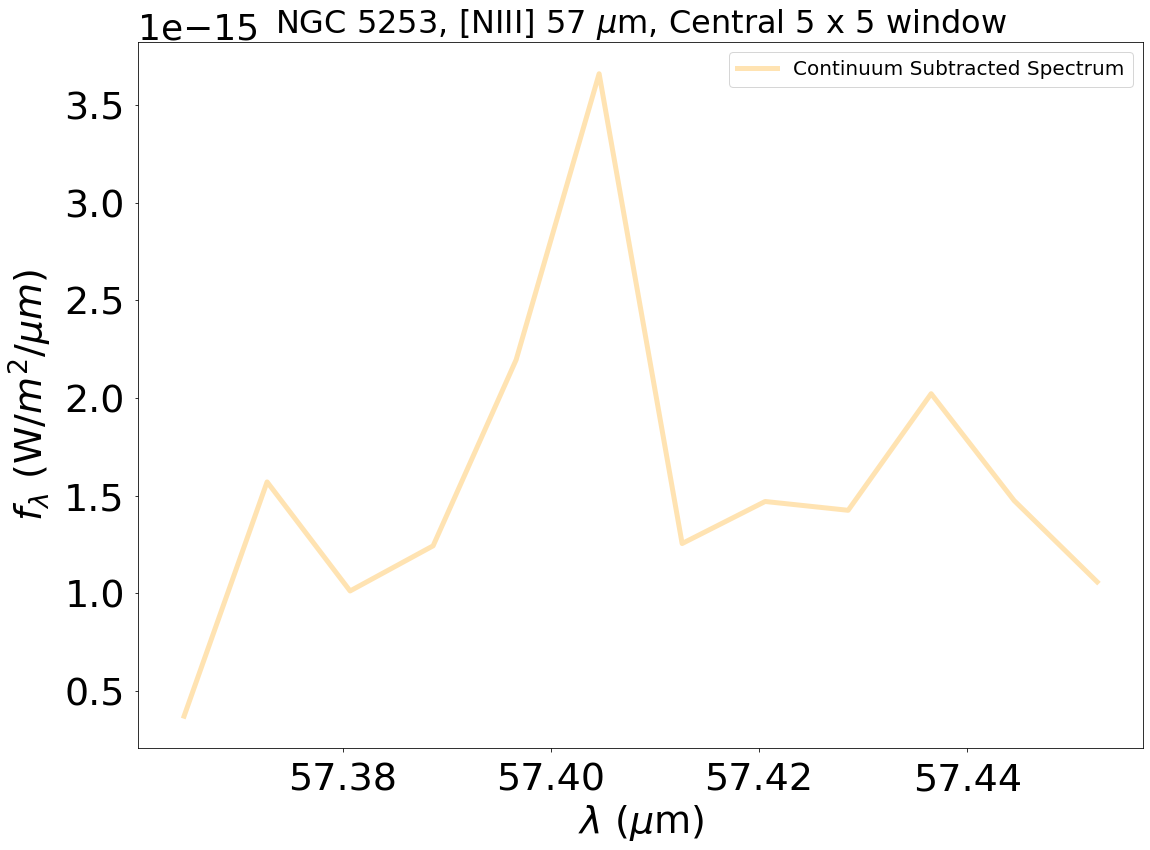

In [17]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 5253, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_5253_[NIII]-4-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

print(central_fluxes_continuum_subtracted_act)

In [18]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [19]:
heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

centers = wavelengths_act

# Information about the peak in the numerical PDF
peak_ind = np.where(heights == np.max(heights))[0][0]
peak_height = np.max(heights)

# mu is where the numerical PDF peaks
mu = centers[peak_ind]

# Estimating sigma using FWHM
sigma = 0

for i in range(0, peak_ind):
    if(heights[i] >= peak_height/2):
        sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
        break

# First fit a Gaussian

guess_params = np.array([peak_height, sigma])
fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                           fit_func_1(centers, peak_height, mu, sigma), 
                                           centers, heights, p0=guess_params)

fit_params = [fit_params[0], mu, fit_params[1]]

fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)

print(fit_params)

[2.0836325360025016e-15, 57.404640633095525, 0.034016905102502784]


[1.04875969e-15 1.08504599e-15 1.12161805e-15 1.15842126e-15
 1.19539858e-15 1.23249066e-15 1.26963600e-15 1.30677104e-15
 1.34383040e-15 1.38074700e-15 1.41745226e-15 1.45387631e-15
 1.48994818e-15 1.52559604e-15 1.56074744e-15 1.59532949e-15
 1.62926918e-15 1.66249358e-15 1.69493012e-15 1.72650684e-15
 1.75715267e-15 1.78679766e-15 1.81537329e-15 1.84281268e-15
 1.86905090e-15 1.89402520e-15 1.91767524e-15 1.93994339e-15
 1.96077490e-15 1.98011815e-15 1.99792490e-15 2.01415040e-15
 2.02875369e-15 2.04169768e-15 2.05294934e-15 2.06247986e-15
 2.07026474e-15 2.07628392e-15 2.08052186e-15 2.08296758e-15
 2.08361476e-15 2.08246171e-15 2.07951142e-15 2.07477154e-15
 2.06825432e-15 2.05997658e-15 2.04995965e-15 2.03822925e-15
 2.02481538e-15 2.00975223e-15 1.99307800e-15 1.97483472e-15
 1.95506815e-15 1.93382751e-15 1.91116530e-15 1.88713711e-15
 1.86180137e-15 1.83521911e-15 1.80745372e-15 1.77857070e-15
 1.74863742e-15 1.71772284e-15 1.68589723e-15 1.65323195e-15
 1.61979915e-15 1.585671

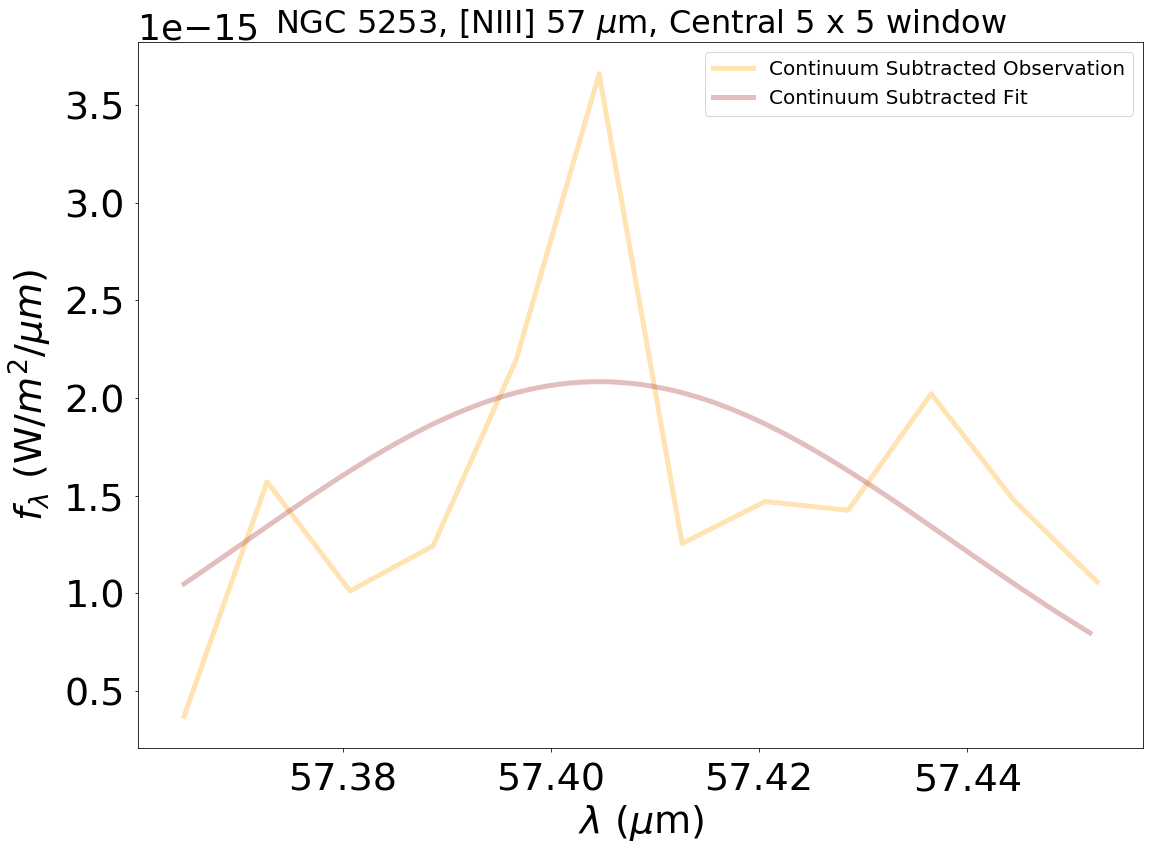

In [20]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)

fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 5253, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_5253_[NIII]-5-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

[1.04875969e-15 1.08504599e-15 1.12161805e-15 1.15842126e-15
 1.19539858e-15 1.23249066e-15 1.26963600e-15 1.30677104e-15
 1.34383040e-15 1.38074700e-15 1.41745226e-15 1.45387631e-15
 1.48994818e-15 1.52559604e-15 1.56074744e-15 1.59532949e-15
 1.62926918e-15 1.66249358e-15 1.69493012e-15 1.72650684e-15
 1.75715267e-15 1.78679766e-15 1.81537329e-15 1.84281268e-15
 1.86905090e-15 1.89402520e-15 1.91767524e-15 1.93994339e-15
 1.96077490e-15 1.98011815e-15 1.99792490e-15 2.01415040e-15
 2.02875369e-15 2.04169768e-15 2.05294934e-15 2.06247986e-15
 2.07026474e-15 2.07628392e-15 2.08052186e-15 2.08296758e-15
 2.08361476e-15 2.08246171e-15 2.07951142e-15 2.07477154e-15
 2.06825432e-15 2.05997658e-15 2.04995965e-15 2.03822925e-15
 2.02481538e-15 2.00975223e-15 1.99307800e-15 1.97483472e-15
 1.95506815e-15 1.93382751e-15 1.91116530e-15 1.88713711e-15
 1.86180137e-15 1.83521911e-15 1.80745372e-15 1.77857070e-15
 1.74863742e-15 1.71772284e-15 1.68589723e-15 1.65323195e-15
 1.61979915e-15 1.585671

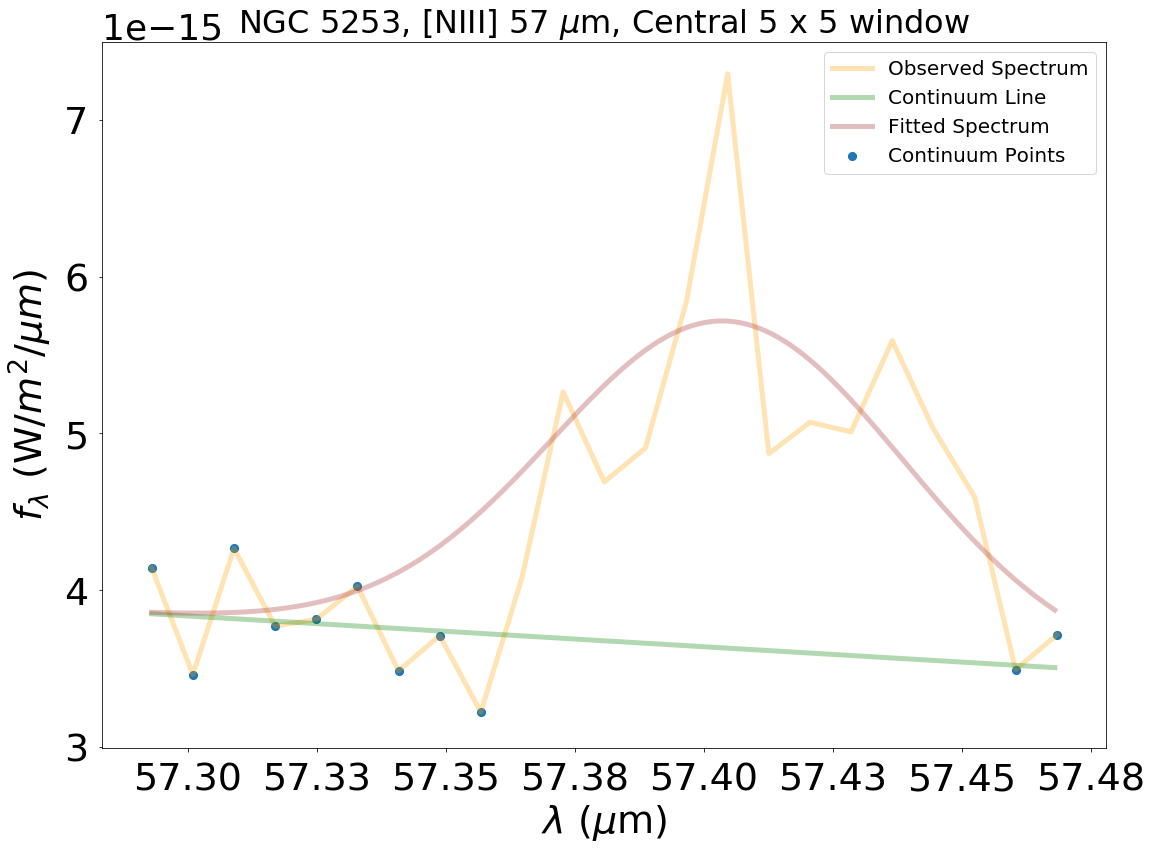

In [21]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]
fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 5253, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_5253_[NIII]-6-final_spectrum.png'.format(str(n_x), str(n_y)))

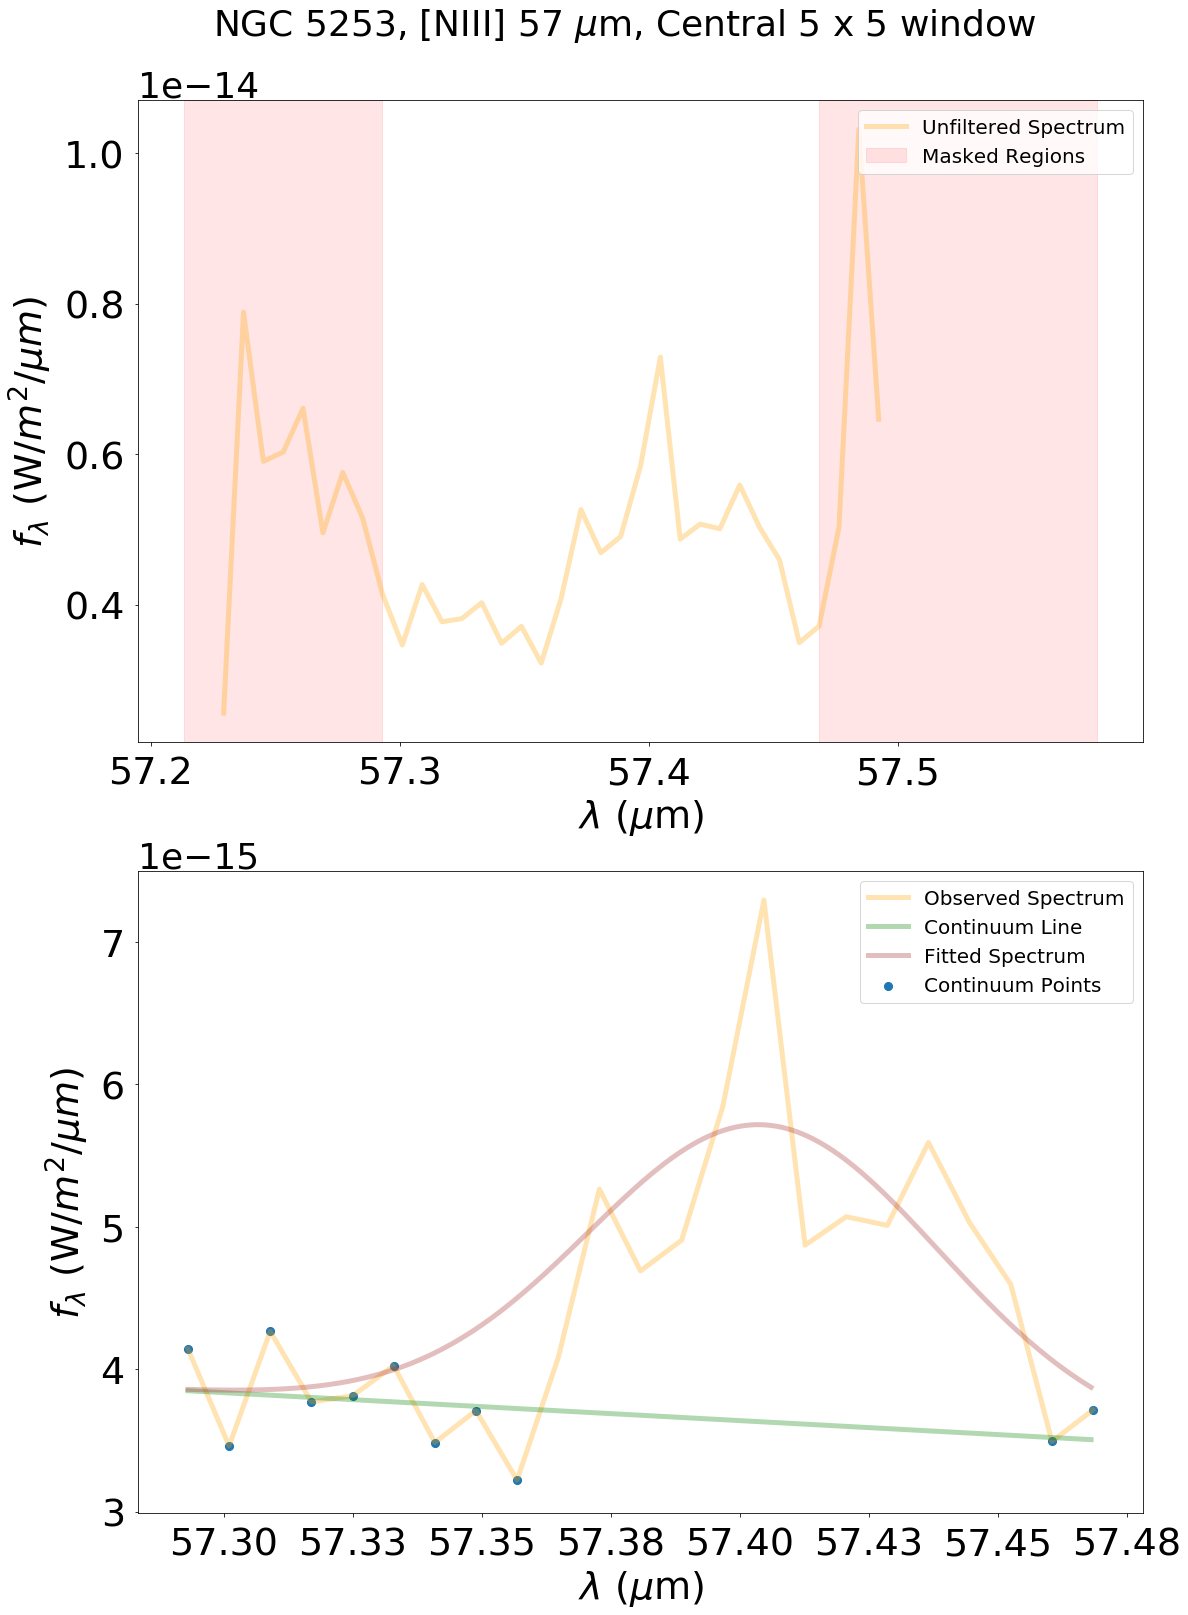

In [24]:
fig, axs = plt.subplots(2, 1, figsize = (18, 26))

ax1 = axs[0]

ax1.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax1.axvspan(wavelengths[0], wavelengths[10], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax1.axvspan(wavelengths[-15], wavelengths[-1], color = 'red', alpha = 0.1)

ax1.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax1.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax1.tick_params(labelsize = 38, pad = 10)
ax1.yaxis.offsetText.set_fontsize(36)
ax1.legend(prop={'size': 20}, loc = 'upper right')

ax2 = axs[1]

ax2.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax2.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax2.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax2.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax2.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax2.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax2.tick_params(labelsize = 38, pad = 10)
ax2.yaxis.offsetText.set_fontsize(36)
ax2.legend(prop={'size': 20}, loc = 'upper right')
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.suptitle(r'NGC 5253, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 36, y = 0.93)

plt.savefig(savedir + 'NGC_5253_[NIII]-7-summary_spectrum.png'.format(str(n_x), str(n_y)))

In [23]:
flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
flux_obs_sub = flux_obs - flux_continuum
print('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2')

flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
flux_fit_sub = flux_fit - flux_continuum
print('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2')

print('Spectral width = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')

Flux of the continuum subtracted observation = 1.4888527821994188e-16 W/m^2
Flux of the continuum subtracted fit = 1.7203157082551914e-16 W/m^2
Spectral width = 0.056641862400805015 microns
